# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

List of tricks to train GANs: https://github.com/soumith/ganhacks

In [25]:
# Import the necessary modules

import os
from typing import Tuple, List

import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FC-GAN for the Generation of Fake MNIST Data


In [26]:
# Frist load the MNist dataset from pytorch

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

### This is what the MNist data looks like:

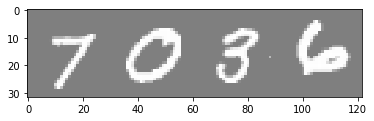

    7     0     3     6


In [38]:
batch_size = 32
lr = 0.0002
train_epoch = 50
trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images[:4,:,:,:])

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### The adverserial Networks:



#### The Generative Network:

Input: x values sampled from uniform distribution

Output: 32 x 32 Image, that should look like the data from MNist 

In [28]:
# The Generative Network

class generativeNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 32, out_features=6 * 6)
        
        self.fc2 = nn.Linear(in_features= 6 * 6, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=24 * 24)
        
        self.fc4 = nn.Linear(in_features= 24 * 24, out_features=28 * 28)
        
        self.ReLU = nn.LeakyReLU()
 
    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return x

#### The discriminative network:

Input: Takes 32 x 32 Image as Input
Output: probability of it being real data (non generated)

In [29]:


class discrimNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 28 * 28, out_features=22 * 22)
        
        self.fc2 = nn.Linear(in_features= 22 * 22, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=6 * 6)
        
        # 2 class fake and real data
        self.fc4 = nn.Linear(in_features= 6 * 6, out_features=2)
        
        self.ReLU = nn.LeakyReLU()
        
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        
        x = x.view(x.shape[0], 28 * 28)
    
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return self.soft(x)

### Define The Noise Prior for the Generative Network:

In [30]:
# Define The Noise Distribution, we us the Gaussian Nosie Distribution:

# always use the same seed to get the same random variables
# np.random.seed(0)

# Here is how to sample a vector of 10 values from uniform distribution
s = np.random.uniform(0,1, 10)
print(s)

[0.80385513 0.97347341 0.19197709 0.73554802 0.23188602 0.02615615
 0.48199093 0.49991573 0.19084786 0.34915562]


### Simple helper functions


In [31]:
# function for sampling the noise data

def sample_noise(batch_size=batch_size):
    noise_batch = []
    for i in range(batch_size):
        mu, sigma = 0, 0.1 # mean and standard deviation
        s = np.random.normal(mu, sigma, 32)
        #s = np.random.uniform(0,1, 10) # 10 values sample from uniform distribution
        noise_batch.append(s)

    noise_batch = torch.from_numpy(np.asarray(noise_batch)).float() 
    return noise_batch

In [32]:
# function to plot the losses

def plot_losses(loss_g, loss_d):
    xg = [i for i in range(len(loss_g))]
    xd = [i for i in range(len(loss_d))]
    plt.plot( loss_g, label='g')
    plt.plot( loss_d, label='d')

    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    plt.title("Loss of D ang G")

    plt.legend()

    plt.show()

### Train the Networks:

In [33]:
torch.cuda.get_device_capability(device=None)
torch.cuda.get_device_name(device=None)

'GeForce GTX 1050'

In [34]:
# calculate the real labels
a_real = []
a_fake = []
for i in range(batch_size):
    sub1 = [1]
    sub2 = [0]
    for j in range(1):
        sub1.append(0)
        sub2.append(1)
    a_real.append(sub1)
    a_fake.append(sub2)

labels_real = torch.tensor(a_real, dtype=torch.float).cuda()
labels_fake = torch.tensor(a_fake, dtype=torch.float).cuda()

In [39]:
G = generativeNet()
D = discrimNet()
G.to(device)
D.to(device)

# Define a Loss function and optimizer
optimizer1 = optim.Adam(D.parameters(), lr=lr)
optimizer2 = optim.Adam(G.parameters(), lr=lr)
# k = discriminator interations
k = 4

criterion = nn.BCELoss()

loss_g = []
loss_d = []

# Train the network
for epoch in range(train_epoch):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            # sample batch_size * 10 matrix of uniform distributed noise
            noise = sample_noise(batch_size).to(device)
            outputs_fake = D(G(noise).detach())
            outputs_real = D(inputs)
            #train d on real images
            loss = criterion(outputs_real, labels_real)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            #train d on fake images
            loss = criterion(outputs_fake, labels_fake)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] D loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_d.append(running_loss)
                running_loss = 0.0

    # 1 training step for G
    print("\t\t Running %dth iteration on G" % epoch)
    running_loss = 0.0
    for i in range(200):
        optimizer2.zero_grad()
        noise = sample_noise(batch_size).to(device)
        loss = criterion(D(G(noise)), labels_real)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] G loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_g.append(running_loss)
                running_loss = 0.0

print('Finished Training')

Currently running epoch Nbr 0
	[1,   100] D loss: 0.412893598
	[1,   200] D loss: 0.001793111
	[2,   100] D loss: 0.000184609
	[2,   200] D loss: 0.000085363
	[3,   100] D loss: 0.000038107
	[3,   200] D loss: 0.000024663
	[4,   100] D loss: 0.000014610
	[4,   200] D loss: 0.000010727
		 Running 0th iteration on G
	[4,   100] G loss: 0.678772153
	[4,   200] G loss: 0.000585159
Currently running epoch Nbr 1
	[1,   100] D loss: 0.337954483
	[1,   200] D loss: 0.000184988
	[2,   100] D loss: 0.000057941
	[2,   200] D loss: 0.000034874
	[3,   100] D loss: 0.000020855
	[3,   200] D loss: 0.000014368
	[4,   100] D loss: 0.000010045
	[4,   200] D loss: 0.000007423
		 Running 1th iteration on G
	[4,   100] G loss: 0.786322852
	[4,   200] G loss: 0.000100603
Currently running epoch Nbr 2
	[1,   100] D loss: 0.242761231
	[1,   200] D loss: 0.000145292
	[2,   100] D loss: 0.000045116
	[2,   200] D loss: 0.000032554
	[3,   100] D loss: 0.000016721
	[3,   200] D loss: 0.000015087
	[4,   100] D loss

	[3,   200] D loss: 0.000691828
	[4,   100] D loss: 0.000418989
	[4,   200] D loss: 0.000302587
		 Running 21th iteration on G
	[4,   100] G loss: 0.756061689
	[4,   200] G loss: 0.000188191
Currently running epoch Nbr 22
	[1,   100] D loss: 0.400826033
	[1,   200] D loss: 0.012276207
	[2,   100] D loss: 0.003917573
	[2,   200] D loss: 0.002157255
	[3,   100] D loss: 0.001227338
	[3,   200] D loss: 0.000850069
	[4,   100] D loss: 0.000585200
	[4,   200] D loss: 0.000582150
		 Running 22th iteration on G
	[4,   100] G loss: 0.835913795
	[4,   200] G loss: 0.000640917
Currently running epoch Nbr 23
	[1,   100] D loss: 0.180006950
	[1,   200] D loss: 0.000604474
	[2,   100] D loss: 0.000286810
	[2,   200] D loss: 0.000194985
	[3,   100] D loss: 0.000116376
	[3,   200] D loss: 0.000090337
	[4,   100] D loss: 0.000063348
	[4,   200] D loss: 0.000063423
		 Running 23th iteration on G
	[4,   100] G loss: 0.597591599
	[4,   200] G loss: 0.003424577
Currently running epoch Nbr 24
	[1,   100] D 

		 Running 42th iteration on G
	[4,   100] G loss: 0.000000000
	[4,   200] G loss: 0.000000000
Currently running epoch Nbr 43
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.910122727
	[2,   200] D loss: 27.910122727
	[3,   100] D loss: 27.910122727
	[3,   200] D loss: 27.910122727
	[4,   100] D loss: 27.910122727
	[4,   200] D loss: 27.910122727
		 Running 43th iteration on G
	[4,   100] G loss: 0.000000000
	[4,   200] G loss: 0.000000000
Currently running epoch Nbr 44
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.910122727
	[2,   200] D loss: 27.910122727
	[3,   100] D loss: 27.910122727
	[3,   200] D loss: 27.910122727
	[4,   100] D loss: 27.910122727
	[4,   200] D loss: 27.910122727
		 Running 44th iteration on G
	[4,   100] G loss: 0.000000000
	[4,   200] G loss: 0.000000000
Currently running epoch Nbr 45
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.91012

In [43]:
for epoch in range(5):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            # sample batch_size * 10 matrix of uniform distributed noise
            noise = sample_noise(batch_size).to(device)
            outputs_fake = D(G(noise).detach())
            outputs_real = D(inputs)
            #train d on real images
            loss = criterion(outputs_real, labels_real)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            #train d on fake images
            loss = criterion(outputs_fake, labels_fake)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] D loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_d.append(running_loss)
                running_loss = 0.0

    # 1 training step for G
    print("\t\t Running %dth iteration on G" % epoch)
    running_loss = 0.0
    for i in range(200):
        optimizer2.zero_grad()
        noise = sample_noise(batch_size).to(device)
        loss = criterion(D(G(noise)), labels_real)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()
        if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] G loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                loss_g.append(running_loss)
                running_loss = 0.0

print('Finished Training')

Currently running epoch Nbr 0
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.910122727
	[2,   200] D loss: 27.910122727
	[3,   100] D loss: 27.910122727
	[3,   200] D loss: 27.910122727
	[4,   100] D loss: 27.910122727
	[4,   200] D loss: 27.910122727
		 Running 0th iteration on G
	[4,   100] G loss: 0.000000000
	[4,   200] G loss: 0.000000000
Currently running epoch Nbr 1
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.910122727
	[2,   200] D loss: 27.910122727
	[3,   100] D loss: 27.910122727
	[3,   200] D loss: 27.910122727
	[4,   100] D loss: 27.910122727
	[4,   200] D loss: 27.910122727
		 Running 1th iteration on G
	[4,   100] G loss: 0.000000000
	[4,   200] G loss: 0.000000000
Currently running epoch Nbr 2
	[1,   100] D loss: 27.910122727
	[1,   200] D loss: 27.910122727
	[2,   100] D loss: 27.910122727
	[2,   200] D loss: 27.910122727
	[3,   100] D loss: 27.910122727
	[3,   200] D loss: 27.910122

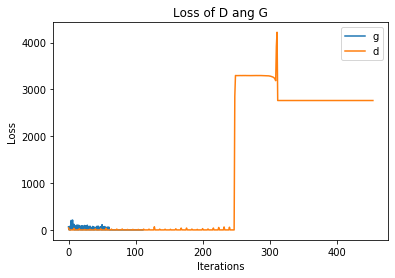

In [44]:
plot_losses(loss_g, loss_d)

tensor([[ 0.1800, -0.0415,  0.1013,  0.0129, -0.0208, -0.0507,  0.0558,  0.1591,
          0.0951, -0.0200, -0.0605,  0.0401, -0.0665,  0.0623, -0.0214, -0.0644,
         -0.0965, -0.0014, -0.0717,  0.1003, -0.2668, -0.0541,  0.0649, -0.1167,
          0.1039, -0.0686,  0.0501, -0.0763, -0.1529, -0.0577,  0.0239, -0.1958]],
       device='cuda:0')
torch.Size([1, 784])
torch.Size([28, 28])


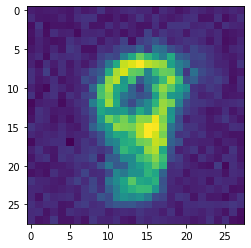

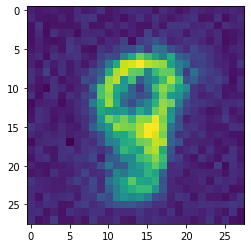

tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1., 0.]], device='cuda:0', grad_fn=<SoftmaxBackward>)


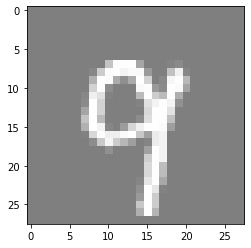

In [71]:
s = sample_noise(1).cuda()
t = sample_noise(1).cuda()
print(s)

a = G(s)
print(a.shape)
a = torch.reshape(G(s), (28,28)).cpu()
print(a.shape)
img = torchvision.utils.make_grid(a)

#img = img / 2 + 0.5     # unnormalize
npimg = a.detach().numpy()
#plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.imshow(npimg)
plt.show()


img = torchvision.utils.make_grid(a)

plt.imshow(torch.reshape(G(t), (28,28)).cpu().detach().numpy())
plt.show()


print(D(G(s).detach()))


trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(D(images[0].to(device)))

img = torchvision.utils.make_grid(images[0])

img = img / 2 + 0.5
#print(images[0])
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
